# Topic

## 1. Introduction

Auditing is the process of investigating financial records of businesses to ensure that their financial statements align with the internationally-accepted legal standards. The data set used in this project is the collection of present and historical risk factors relevant to assisting auditors in appropriately identifying businesses that are risky of committing unfair practices (N. Hooda et al., 2018).

Precisely, we will be using the Audit Data collected by the Comptroller and Auditor General (CAG). CAG of India is an independent constitutional body entrusted with the task of auditing the financial transactions of government-funded firms. They collected comprehensive non-confidential data from the Auditor General Office (AGO), with a focus on 777 firms from 46 Indian cities between the years 2015 to 2016. The target companies were then grouped into 14 different sectors.

This data analytic project revolves around the application of predictive analytics in the classification of fraudulent firms using the case study above. Therefore, this project will attempt to tackle the following research question: Is a business risky or not risky of committing fraud based on its Inherent, Control and Detection Risk scores?

The variables we will use to answer this question are the potential discrepancies that can occur during the companies’ transactions (Inherent Risk), internal audit (Control Risk) and external audit (Detection Risk). The product of these variables will give us the Audit Risk score (ARS). In the risk assessment, the companies with ARS scores more than or equal to 1 are identified as “risky” firms and are assigned a risk assessment value of 1, and companies scoring less than 1 are classified as “not risky” firms, getting a risk assessment score of 0.


## 2. Preliminary Explanatory Data Analysis

In [52]:
#load library
options(repr.matrix.max.rows=8)
library(tidyverse)
library(tidymodels)
library(repr)
library(cowplot)

In [53]:
#Read dataset and correct variable types
audit_data <- read_csv("data/audit_risk.csv") |>
    mutate(Risk = as.factor(Risk)) |>
    mutate(LOCATION_ID = as.integer(LOCATION_ID))

#Splitting data into training set and testing set
set.seed(265)
audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_training <- training(audit_split)
audit_testing <- testing(audit_split)

#Printing training data set
audit_training

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0
3.89,8,3.98,0.6,2.388,0.99,0.2,0.198,4.97,5,⋯,0.4,0,0.2,0,2.4,4.372,0.4,0.5,0.8744,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,2,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,1.2,0,0.2,0,2.4,2.200,1.2,0.5,1.3200,1
55.57,2,1.06,0.4,0.424,0.63,0.2,0.126,1.69,5,⋯,1.2,0,0.2,0,2.6,2.930,1.2,0.5,1.7580,1
55.57,32,0.00,0.2,0.000,8.49,0.6,5.094,8.49,5,⋯,0.4,0,0.2,0,3.2,6.580,0.4,0.5,1.3160,1
55.57,13,1.06,0.4,0.424,1.60,0.4,0.640,2.66,5,⋯,0.4,0,0.2,0,3.2,12.118,0.4,0.5,2.4236,1


Although the dataset does not include sector ID for each unique sector, we hypothesized that every individual sector should have its own historical risk score value (Sector_score). Thus, we will count how many unique sector scores there are, and the respective number of firms under each sector score. 

In [54]:
#Table reporting number of sectors and number of firms under each sector
firm_count <- audit_training |>
    select(LOCATION_ID) |>
group_by(LOCATION_ID) |>
    summarise(firm_count = n())
print(firm_count)

# A tibble: 42 × 2
   LOCATION_ID firm_count
         <int>      <int>
 1           1          9
 2           2         33
 3           3          3
 4           4         27
 5           5         35
 6           6         27
 7           7          4
 8           8         58
 9           9         42
10          11         18
# … with 32 more rows


The table above shows 13 different unique sector scores, however, there are supposed to be 14 sectors (N. Hooda et al., 2018). This also does not match up with some of the firm counts under each sector i.e. there should be 70 companies with 2.37 sector score and 77 with a sector score of 3.41. A reason for this could be that some sectors have equal sector risk scores, making the sector_score an inaccurate variable to count for the number of sectors and the number of firms under them. 

### Average

In [76]:
average_risk_factors <- audit_training |> 
    select(LOCATION_ID, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk)  |> 
    group_by(LOCATION_ID)  |> 
    map_dfc(mean, na.rm = TRUE)
average_risk_factors

LOCATION_ID,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14.57168,17.66497,0.5772806,0.5,6.275287


### Relationship between variables

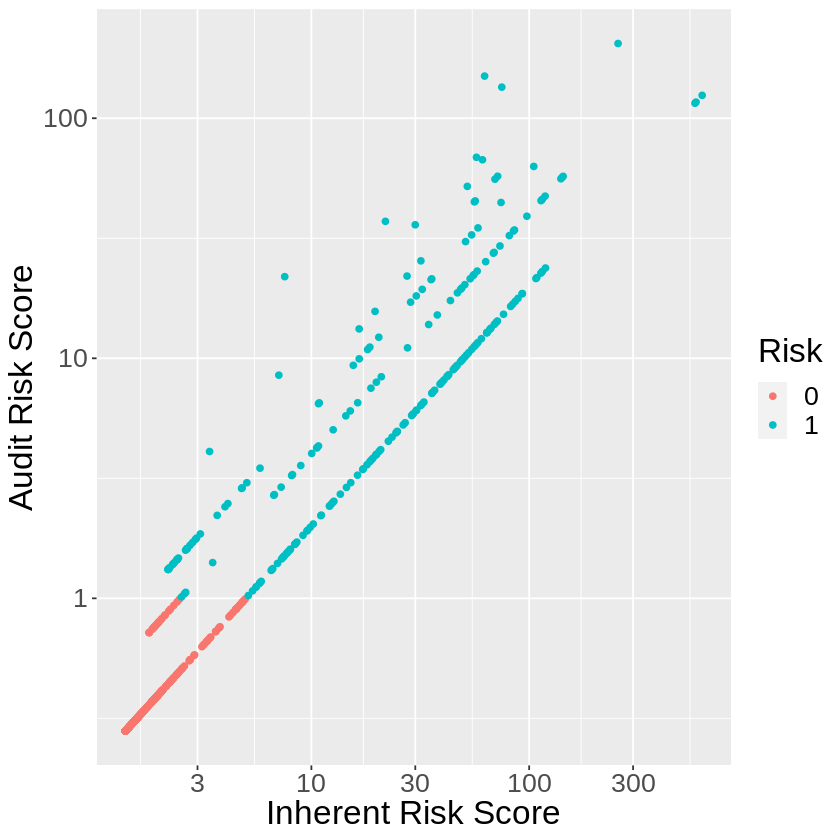

In [55]:
IR_AR_plot <- audit_training |>
    ggplot(aes(x = Inherent_Risk, y = Audit_Risk))+
    geom_point(aes(colour = Risk))+
    labs(x = "Inherent Risk Score", y = "Audit Risk Score", colour = "Risk")+
    scale_x_log10(labels = comma)+
    scale_y_log10(labels = comma)+
    theme(text = element_text(size =20))
IR_AR_plot

Warning message:
“Removed 2 rows containing non-finite values (stat_bin).”


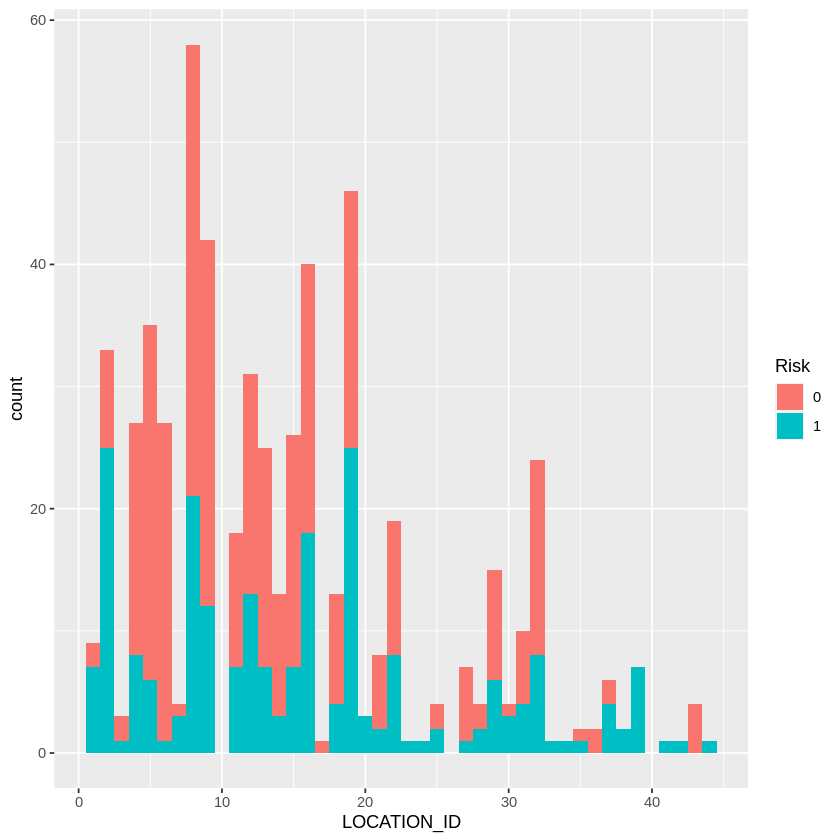

In [88]:
Risk_proportion <- audit_training |>
    ggplot(aes(LOCATION_ID, fill = Risk))+
    geom_histogram(binwidth = 1)
Risk_proportion

May have to add summary table here

### For later

In [72]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_recipe <- recipe(Risk ~ Inherent_Risk + CONTROL_RISK + Detection_Risk, data = audit_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

audit_fit <- workflow() |>
    add_recipe(audit_recipe) |>
    add_model(knn_spec) |>
    fit(data = audit_training)

audit_predict <- predict(audit_fit, audit_training) |>
    bind_cols(audit_training) |>
    select(.pred_class, Risk)
audit_predict

Warning message:
“Column(s) have zero variance so scaling cannot be used: `Detection_Risk`. Consider using `step_zv()` to remove those columns before normalizing”
New names:
• `Score_B...7` -> `Score_B...8`
• `Score_B...11` -> `Score_B...12`


.pred_class,Risk
<fct>,<fct>
0,0
0,0
0,0
0,0
⋮,⋮
1,1
1,1
1,1
1,1


In [73]:
audit_prediction_accuracy <- audit_predict |>
    metrics(truth = Risk , estimate = .pred_class)
audit_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9982788
kap,binary,0.9963878


## 3. Methods

We will conduct our data analysis using the K-nearest neighbors (K-NN) classification model. The variables that will be included are the Inherent risk, Combined Risk and the Detection Risk (DR) against the Audit Risk score. Using K-NN will help predict what group the new observations in the testing data will be classified under (risk or not risky). The results will be visualized using scatter plots to determine the respective relationships of each of the three risk factors (Inherent risk, Combined Risk and the Detection Risk) with the audit risk. By doing so, we can see how each risk factor directly impacts the audit score and we can compare the strengths of each relationship to identify which risk factor influences the audit risk score the greatest. 

## 4. Expected Outcomes and Significance

Since Detection_Risk is kept constant at 0.5 throughout the dataset, for businesses with low individual Inherent_Risk and CONTROL_RISK scores, we expect them to have a low Audit Risk score (less than 1) and therefore have a Risk Assessment score of 0, classifying them as “not risky”. In contrast, for businesses with high individual Inherent and Control risk scores, we expect them to have a high Audit Risk score (greater than or equal to 1) and therefore have a Risk Assessment score of 1, classifying them as “risky”.

We can identify the businesses that pose the most risk of committing fraud, and try to create advanced models to improve auditing practices for future investigations. These auditing practices will allow businesses to reduce their level of audit risk which will show a low risk of misstatement in the financial statement of the organization. 

While these findings can help improve auditing practices for future investigations, it also brings up the future question on how companies with high audit risk scores can be prevented from committing fraud in the future. It is very important for these companies to maintain a modest level of audit risk. Another future question that this could lead to is if there is any way we can reduce the number of companies that commit fraud. Finally, what are the main causes of companies who have high Audit Risk in the first place? 